# Assess Bot Impact
This code will calculate the mean opinion shift caused by the bots in your network. 

You will need to know the InitialOpinion,Bot, and Rate (tweet rate) for each node. 

You will need to know the follower graph for the nodes

In [1]:
from assess_helper import *
import matplotlib.pyplot as plt
import numpy as np
import pandas as df
from scipy import sparse
import sys

## Input Files

These are the input file u need to make for the assessment stage.
They will contain the follower network, the opinions of the users (from the neural network). The identities of bots (from the bot detector code), and the stubborn users (we get this from the opinions, but assume now its been figured out)

INPUT:

node_filename = file with node info.  Format is (id,InitialOpinion,Stubborn,Rate,Bot,friend_count, follower_count)

follower_graph_filename = file with following of each node in the network.
format is (follower, following1,following2,following3,...)

G_filename = filename for networkx object for entire follower network. Make sure it ends in .gpickle.  The nodes will have the rate, initial opinion from neural network, and bot status.

Gbot_filename =  filename for networkx object for follower network reachable from stubborn users. Make sure it ends in .gpickle.  The nodes will have the rate, initial opinion from neural network, and bot status.

assess_csv_filename = csv file with opinions of each user with and without bots.  This is for plotting purposes.

In [52]:
#Test files
node_filename = "test_nodes.csv"  #format is (id,InitialOpinion,Stubborn,Rate,Bot, friend_count, follower_count)
follower_graph_filename = "test_follower_graph.csv" #format is (follower, following1,following2,following3,...)
G_filename = 'G.gpickle'
Gbot_filename = 'G_bot.gpickle'
assess_csv_filename = "assess_test.csv"


#country = "India"
#path_data = "C:\\Users\\Zlisto\\Dropbox (Personal)\\MIDAC\\UNWomen\\"
#node_filename =path_data+"Nodes_%s_All.csv"%country
#follower_graph_filename = path_data+ "friends_graph_%s_combined.csv"%country
#G_filename = path_data+ "G_%s.gpickle"%country
#G_bot_follower_filename = path_data + "friends_graph_%s_bot_followers.csv"%country
#Gbot_filename = path_data+"Gbot_UNWomen_%s.gpickle"%country
#ff_filename = path_data+ "sn_ff_%s_all.csv"%country
#assess_csv_filename = path_data + "assess_%s.csv"%country

## Histogram Neural Network Opinions

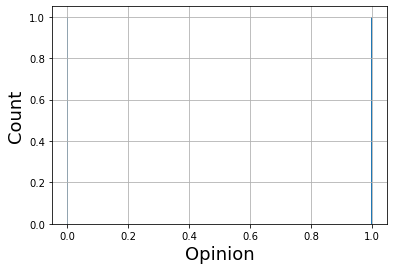

In [28]:
df = pd.read_csv(node_filename)
plt.hist(df.InitialOpinion,1000);
plt.grid()
plt.xlabel("Opinion",fontsize = 18)
plt.ylabel("Count",fontsize = 18)

plt.show()



## Choose Opinion Thresholds
Choose opinion thresholds to determine who is stubborn.
INPUT:

threshold_low = highest opinion of stubborn users in lower interval

threshold_high= lowest opinion of stubborn users in upper interval

OUTPUT:

G = networkx object with all node and network info.  This is what you will need for the assess steps.

Building network for Assess.
Stubborn intervals = (0,0.100),(0.960,1)
Wrote network to file.  Network as 5 nodes and 5 edges


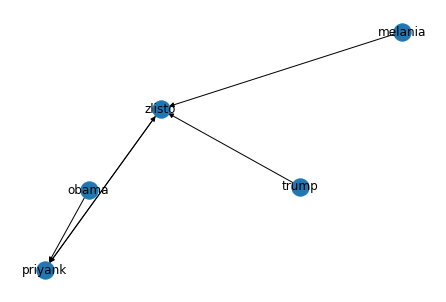

In [29]:
#threshold_low = np.quantile(df.InitialOpinion,0.05)
#threshold_high= np.quantile(df.InitialOpinion,0.95)

threshold_low = 0.1
hreshold_high= 0.9

G = G_from_follower_graph(node_filename,follower_graph_filename,threshold_low,threshold_high)  #create network_x graph object
nx.write_gpickle(G, G_filename)
print("Wrote network to file.  Network as %s nodes and %s edges"%(G.number_of_nodes(),G.number_of_edges()))
#G = nx.read_gpickle(G_filename)

if G.number_of_nodes()<=100:
    pos = nx.spring_layout(G)
    nx.draw(G,pos=pos)
    nx.draw_networkx_labels(G,pos=pos)

## Prepare Reachable Subgraph

This function builds a subgraph that contains the stubborn users and anyone they can reach.
We need this step because if you cannot be reached by a stubborn user, my model has no way to determine ur opinion.

INPUT:

G = follower network with node information (neural network opinion, rate, bot status)

OUTPUT:

Gbot0 = sugbraph of G that has only nodes that can be reached by at least one stubborn node.  

Checking reachable nodes from 2 stubborn nodes
Did reach check for only 2 nodes out of 5
Original Follower network has 5 nodes and 5 edges
Stubborn reachable Follower network has 4 nodes and 4 edges


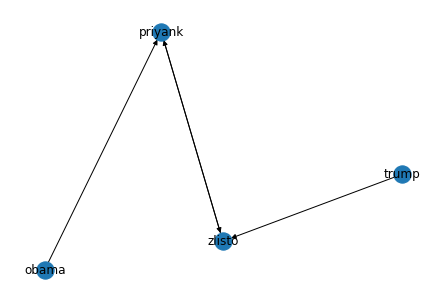

In [30]:
(Gbot0,Vbot) = reachable_from_stubborn(G)
print("Original Follower network has %s nodes and %s edges"%(G.number_of_nodes(),G.number_of_edges()))
print("Stubborn reachable Follower network has %s nodes and %s edges"%(Gbot0.number_of_nodes(),Gbot0.number_of_edges()))

nx.write_gpickle(Gbot0.copy(),Gbot_filename)
if Gbot0.number_of_nodes()<=100:
    pos = nx.spring_layout(Gbot0)
    nx.draw(Gbot0,pos=pos)
    nx.draw_networkx_labels(Gbot0,pos=pos)

## Remove Non-stubborn that cant be reached by stubborn humans and resave Gbot0

Load Gbot0 if you already computed it.  Then keep only nodes
which are not reachable only by bots.  These users cannot be solved
when you remove the bots.  Resave Gbot0.

INPUT:

Gbot0 = sugbraph of G that has only nodes that can be reached by at least one stubborn node.  


OUTPUT:

Gbot0 = sugbraph of G that has only nodes that can be reached by at least one $\textbf{human}$ stubborn node.  

In [31]:
#Use this to read Gbot if you saved it already. For debugging purposes
Gbot0 = nx.read_gpickle(Gbot_filename)
nv = Gbot0.number_of_nodes()
ne = Gbot0.number_of_edges()
print("Gbot0 has %s nodes and %s edges"%(nv,ne))


#create subgraph with bots removed
Gnobot = Gbot0.subgraph([x for x in Gbot0.nodes if Gbot0.nodes[x]["Bot"]==0])
print("Find all nodes reachable from stubborn nodes in Gnobot")
_,Vnobot = reachable_from_stubborn(Gnobot)
      
#get list of bot and human names
Bots = [x for x in Gbot0.nodes if Gbot0.nodes[x]["Bot"]==1]
Humans = [v for v in Vnobot]

#Create subgraph of Gbot with bots and humans reachable by stubborn non-bots
Gbot = Gbot0.subgraph(Bots+Humans)
#save Gbot
nv = Gbot.number_of_nodes()
ne = Gbot.number_of_edges()
print("Gbot with unreachable nodes removed has %s nodes and %s edges"%(nv,ne))

nx.write_gpickle(Gbot.copy(),Gbot_filename)

Gbot0 has 4 nodes and 4 edges
Find all nodes reachable from stubborn nodes in Gnobot
Checking reachable nodes from 1 stubborn nodes
Did reach check for only 1 nodes out of 3
Gbot with unreachable nodes removed has 4 nodes and 4 edges


## Load Gbot

Use this block if you already save Gbot0 with unreachable humans removed.


In [32]:
Gbot0 = nx.read_gpickle(Gbot_filename)
nv = Gbot0.number_of_nodes()
ne = Gbot0.number_of_edges()
print("Gbot0 with unreachable nodes removed has %s nodes and %s edges"%(nv,ne))


Gbot0 with unreachable nodes removed has 4 nodes and 4 edges


## NOT NEEDED: Add in edges from bots to their followers



Edges = []
ne=0  #edge counter
new_edges = 0
with open(G_bot_follower_filename) as fp:
    for cnt, line in enumerate(fp): 
        line = line.strip('\n')
        users =line.split(",")
        following = users[0]
        if following in Gbot0.nodes():
            followers = users[1:]  
            for follower in followers:
                if follower in Gbot0.nodes():
                    if not(Gbot0.has_edge(following, follower)):
                        ne+=1
                        rate = Gbot0.nodes[following]['Rate']
                        Gbot0.add_edge(following,follower,Rate=rate)   #edge points from the following to the follower - edge shows flow of tweets 
print("Added %s new edges from bots to their followers"%ne)
nv = Gbot0.number_of_nodes()
ne = Gbot0.number_of_edges()
print("Gbot0 with unreachable nodes removed has %s nodes and %s edges"%(nv,ne))


## Make sure all bots are stubborn

In [35]:
for node in Gbot0.nodes():
    if (Gbot0.nodes[node]['Bot']==1) and (Gbot0.nodes[node]['Stubborn']==0):
        Gbot0.nodes[node]['Stubborn']=1
print("Updated bot stubborn label so all bots are stubborn\n")
nx.write_gpickle(Gbot0.copy(),Gbot_filename)

Updated bot stubborn label so all bots are stubborn



## Risk Index Calculation

This function calculates the risk index, which equals the shift in the mean opinion of all users (bot and human ) in the network.
We can modify the exact risk index value later, but it uses the Opinions vectors

In [36]:
(ri,OpinionsNoBots,OpinionsBots,Gnobot,Gbot) = risk_index(Gbot0);
nx.write_gpickle(Gbot.copy(),Gbot_filename)

MeanOpinionBots = np.mean(OpinionsBots)
MeanOpinionNoBots = np.mean(OpinionsNoBots)
print("\nMean opinion with no bots = %s"%MeanOpinionNoBots)
print("Mean opinion with bots = %s"%MeanOpinionBots)
print("Risk Index = %.2f"%ri)



Solving for opinions with bots
	Calculating G,F,Psi matrices
	Solving for opinions
Solving for opinions without bots
	Calculating G,F,Psi matrices
	Solving for opinions
Saving opinions to arrays

Mean opinion with no bots = 0.7499999999999996
Mean opinion with bots = 0.5625
Risk Index = -0.19


## Save Assess Data

Save the node info, including equilibrium opinions with and without bots, to a csv file.

In [41]:
def G_to_df(G):
    X = []
    for node in G.nodes(data=True):
        X.append(node[1])
    df = pd.DataFrame(X)
    return df

df = pd.read_csv(node_filename)
df_bot = G_to_df(Gbot)
df_nobot = G_to_df(Gnobot)


df = df.rename(columns={"id": "ScreenName", "InitialOpinion": "OpinionNeuralNet"})
df_bot = df_bot.rename(columns={"Name": "ScreenName", "FinalOpinion": "OpinionEquilibriumBot"})
df_nobot = df_nobot.rename(columns={"Name": "ScreenName", "FinalOpinion": "OpinionEquilibrium"})


X = df_bot[df_bot.Bot==1]
X=X.rename(columns={"OpinionEquilibriumBot": "OpinionEquilibrium"})
df_nobot = df_nobot.append(X)
#get node degrees in observed network
X = []
for sd in  list(Gbot.in_degree()):
    x = {"ScreenName":sd[0],"in_degree":sd[1]}
    X.append(x)
Din = pd.DataFrame(X)
X = []
for sd in  list(Gbot.out_degree()):
    x = {"ScreenName":sd[0],"out_degree":sd[1]}
    X.append(x)
Dout = pd.DataFrame(X)
df_degree = pd.merge(Din,Dout,on="ScreenName",how="inner")


df.set_index('ScreenName')
df_bot.set_index('ScreenName')
df_nobot.set_index('ScreenName')

#df_bot.to_csv(path_data+"df_bot.csv")
#df_nobot.to_csv(path_data+"df_nobot.csv")



df_bot = pd.merge(df,df_bot,on="ScreenName",how="inner")
df_bot = pd.merge(df_degree,df_bot,on = "ScreenName", how = "inner")
df_assess = pd.merge(df_bot,df_nobot, on = "ScreenName")

df_assess = df_assess[["ScreenName","OpinionNeuralNet","OpinionEquilibriumBot",
                      "OpinionEquilibrium","Bot","Stubborn","Rate",
                       "friend_count","follower_count",
                      "in_degree","out_degree"]]

df_assess.to_csv(assess_csv_filename) 
print("Saved assess data to %s"%assess_csv_filename)

Saved assess data to assess_test.csv


In [42]:
df_assess.head()

,ScreenName,OpinionNeuralNet,OpinionEquilibriumBot,OpinionEquilibrium,Bot,Stubborn,Rate,friend_count,follower_count,in_degree,out_degree
0,zlisto,0.5,0.9375,1.0,0,0,1,7,5,2,1
1,trump,1.0,1.0000,1.0,0,1,10,31,10000,0,1
2,obama,0.0,0.0000,0.0,1,1,2,1000,10000,0,1
3,priyank,0.6,0.3125,1.0,0,0,1,5,2,2,1


## Plot Opinion Shift
Plot bar graph of mean opinion with and without bots.


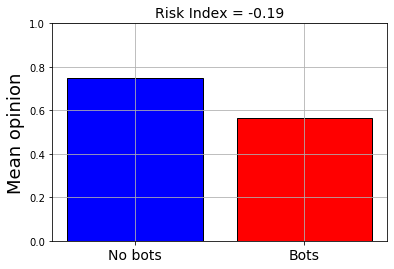

In [43]:
X = np.asarray((1,2))
Y = np.asarray((MeanOpinionNoBots,MeanOpinionBots))
plt.bar(X,Y,color=['blue', 'red'],edgecolor='black')
plt.grid()
plt.xticks(X, ["No bots","Bots"],fontsize=14)
plt.ylim([0, 1]);
plt.ylabel("Mean opinion",fontsize = 18)
plt.title("Risk Index = %.2f"%ri,fontsize = 14);
plt.show()

## Count number bot human followers

Count how many non-stubborn users follow the bots in the follower network
reachable by stubborn humans.


In [47]:
(nbot_followers,nbots,Vbot_followers) = bot_neighbor_count(Gbot)
nv = Gbot.number_of_nodes()
print("%s bots have a total of %s followers in a network of %s users"%(nbots,nbot_followers,nv))

1 bots have a total of 1 followers in a network of 4 users


## Number of Bots followed by each human

Look at how many humans follow different numbers of bots.

In [50]:
Nbots = []
S =[]
for sn in Gbot.nodes():
    if  Gbot.nodes[sn]['Stubborn']==0:
        nb =  Gbot.predecessors(sn)
        bots = [v for v in nb if Gbot.nodes[v]['Bot']==1]
        Nbots.append(len(bots))
        S.append(sn)
df_nbots =  pd.DataFrame(list(zip(S ,Nbots)), 
               columns =['ScreenName', 'Nbots'])
print("Calculated how many bots each human follows")

Calculated how many bots each human follows


In [51]:
for nbots in range(0,10):
    nusers = len(df_nbots[df_nbots.Nbots==nbots])
    print("%s users follow %s bots"%(nusers,nbots))

1 users follow 0 bots
1 users follow 1 bots
0 users follow 2 bots
0 users follow 3 bots
0 users follow 4 bots
0 users follow 5 bots
0 users follow 6 bots
0 users follow 7 bots
0 users follow 8 bots
0 users follow 9 bots
